In [1]:
# various import statements
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import scanpy as sc
import pyro
import cuml

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")
    
import random

import sys
import antipode
from antipode.antipode_model import *
import antipode.model_functions
from antipode.model_functions import *
import antipode.model_distributions
from antipode.model_distributions import *
import antipode.model_modules
from antipode.model_modules import *
import antipode.train_utils
from antipode.train_utils import *
import antipode.plotting
from antipode.plotting import *
from antipode.antipode_mixins import AntipodeTrainingMixin, AntipodeSaveLoadMixin


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 272, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_

GPU is not available


In [2]:
model_tag='1.9.1.8.5_BG'
out_path=os.path.join('/home/matthew.schmitz/Matthew/models/',model_tag)
batch_key='load_id'
discov_key='organism'
layer_key='UMIs'
sex_key = 'self_reported_sex'
species_key=discov_key

In [3]:
adata = sc.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/hct_ux3_cellxgene/anndata_080/BasalGanglia/xspecies/HMBA_Human_Macaque_Marmoset_Mouse_snRNA-seq_BG_alignment_neurons.h5ad")

In [4]:
# import h5py
# import anndata
# with h5py.File("/allen/programs/celltypes/workgroups/rnaseqanalysis/hct_ux3_cellxgene/anndata_080/BasalGanglia/xspecies/HMBA_Human_Macaque_Marmoset_Mouse_snRNA-seq_BG_alignment_neurons.h5ad") as f:
#     obsm = anndata.experimental.read_elem(f['obsm'])
#     obs = anndata.experimental.read_elem(f['obs'])
#     var = anndata.experimental.read_elem(f['var'])

# adata_hvg = adata[:,var.index]
# adata_hvg = adata_hvg[obs.index,:]

# adata_trim = ~(adata.obs["AIT21.nbhd"].isin(["NN-IMN-GC"]) | adata.obs["Neighborhood"].isin(["Nonneuron"]))
# adata = adata[adata_trim]
# adata.obsm = obsm

# import scvi
# model= scvi.model.SCVI.load(dir_path="/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/xspecies/BasalGanglia/pre-print-integration_v6/",adata=adata_hvg.copy())

# ## Save the latent space from scVI for downstream analysis
# adata.obsm["X_scVI"] = model.get_latent_representation()

In [5]:
adata

AnnData object with n_obs × n_vars = 1303988 × 3000
    obs: 'Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster', 'cluster_id', 'cell_type_ontology_term', 'load_id', 'donor_id', 'assay', 'assay_ontology_term_id', 'organism', 'organism_ontology_term_id', 'development_stage', 'anatomical_region', 'anatomical_region_merged', 'anatomical_region_ontology_term_id', 'brain_region_ontology_term_id', 'self_reported_sex', 'self_reported_sex_ontology_term_id', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'disease', 'disease_ontology_term_id', 'suspension_type', 'is_primary_data', 'total_counts', 'total_genes', 'doublet_score', 'organism_sci', 'accession_group', 'embedding_set', 'CL:ID_group', 'tokens_group', 'display_order_group', 'literature_support', 'literature_name_short', 'literature_name_long', 'curated_markers', 'color_hex_group', 'color_group', 'accession_subclass', 'CL:ID_subclass', 'tokens_subclass', 'display_order_subclass', 'color_hex_subclass', 'color_su

In [6]:
adata.obs[sex_key] = adata.obs[sex_key].astype('category')
adata.obs[batch_key] = adata.obs[batch_key].astype('category')
adata.obs[batch_key] = adata.obs[batch_key].cat.remove_unused_categories()
adata.obs['log10_n_counts'] = np.log10(adata.layers[layer_key].sum(1))

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
def distribute_evenly(a, k):
    n = len(a)  # Number of elements
    r = [0] * n  # Initialize result vector with zeros
    
    # First pass: Try to distribute evenly based on the initial total
    avg = k // n
    for i in range(n):
        r[i] = min(a[i], avg)
    
    remaining = k - sum(r)  # Calculate remaining after initial distribution
    
    # Distribute the remaining as evenly as possible
    while remaining > 0:
        # Calculate the updated average for the remaining amount
        updates = 0
        for i in range(n):
            if r[i] < a[i]:
                potential_add = min(a[i] - r[i], remaining // (n - updates))
                if potential_add > 0:
                    r[i] += potential_add
                    remaining -= potential_add
                    updates += 1
                    if remaining == 0:
                        break
        
        # In case there are no updates, but still remaining (to avoid infinite loop)
        if updates == 0:
            break
    
    return r


def select_k_cells(adata, obs_column, k):
    a = adata.obs[obs_column].value_counts()
    categories = a.index

    r = distribute_evenly(a,k)
    
    inds=[]
    for i,cat in enumerate(categories):
        cat_cells = adata.obs.index[adata.obs[obs_column] == cat].tolist()
        inds.append(np.random.choice(cat_cells, size=r[i], replace=False))
    selected_indices=[item for sublist in inds for item in sublist]
    return adata[selected_indices,:]

def consensus_knn_transfer(adata, label_col, train_mask, test_mask, n_neighbors=20, n_iter=10):
    preds_list = []
    adata.obs[label_col + '_propagated'] = list(adata.obs[label_col])
    train_data = adata[train_mask]
    # Determine number of cells to sample from each class
    min_count = train_data.obs[label_col].value_counts().min()
    k_val = len(train_data.obs[label_col].unique()) * min_count * 2

    for _ in tqdm.tqdm(range(n_iter)):
        # Downsample training data evenly
        equalized_train = select_k_cells(train_data, label_col, k_val)
        neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
        X_train = equalized_train.obsm['X_scVI']
        y_train = equalized_train.obs[label_col]
        neigh.fit(X_train, y_train)
        test_data = adata[test_mask]
        X_test = test_data.obsm['X_scVI']
        preds = neigh.predict(X_test)
        preds_list.append(preds)
    
    # Stack predictions from all iterations and take majority vote for each test cell.
    preds_array = np.vstack(preds_list)  # shape: (n_iter, n_test)
    consensus_preds = [
        Counter(preds_array[:, j]).most_common(1)[0][0]
        for j in range(preds_array.shape[1])
    ]
    adata.obs.loc[test_mask, label_col + '_propagated'] = consensus_preds
    return adata


adata.obs['Group'] = adata.obs['Group'].astype(str)
adata.obs['Subclass'] = adata.obs['Subclass'].astype(str)
adata.obs['Class'] = adata.obs['Class'].astype(str)

train_mask = adata.obs['Group']!='nan'
test_mask  = adata.obs['Group']=='nan'
adata = consensus_knn_transfer(adata, 'Group', train_mask, test_mask,
                               n_neighbors=30, n_iter=20)

train_mask = adata.obs['Subclass']!='nan'
test_mask  = adata.obs['Subclass']=='nan'
adata = consensus_knn_transfer(adata, 'Subclass', train_mask, test_mask,
                               n_neighbors=30, n_iter=20)

train_mask = adata.obs['Class']!='nan'
test_mask  = adata.obs['Class']=='nan'
adata = consensus_knn_transfer(adata, 'Class', train_mask, test_mask,
                               n_neighbors=30, n_iter=20)




  0%|          | 0/20 [00:00<?, ?it/s]/scratch/fast/4154810/ipykernel_714239/4070991218.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r[i] = min(a[i], avg)
/scratch/fast/4154810/ipykernel_714239/4070991218.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if r[i] < a[i]:
/scratch/fast/4154810/ipykernel_714239/4070991218.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  potential_add = min(a[i] - r[i], remaining // (n - 

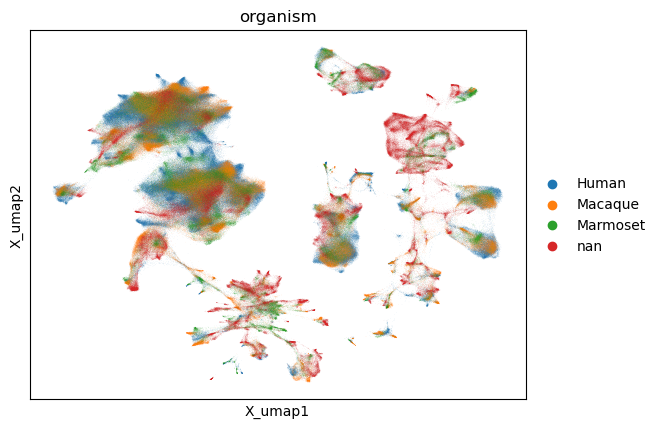

In [8]:
sc.pl.embedding(adata, basis='X_umap',color='organism')

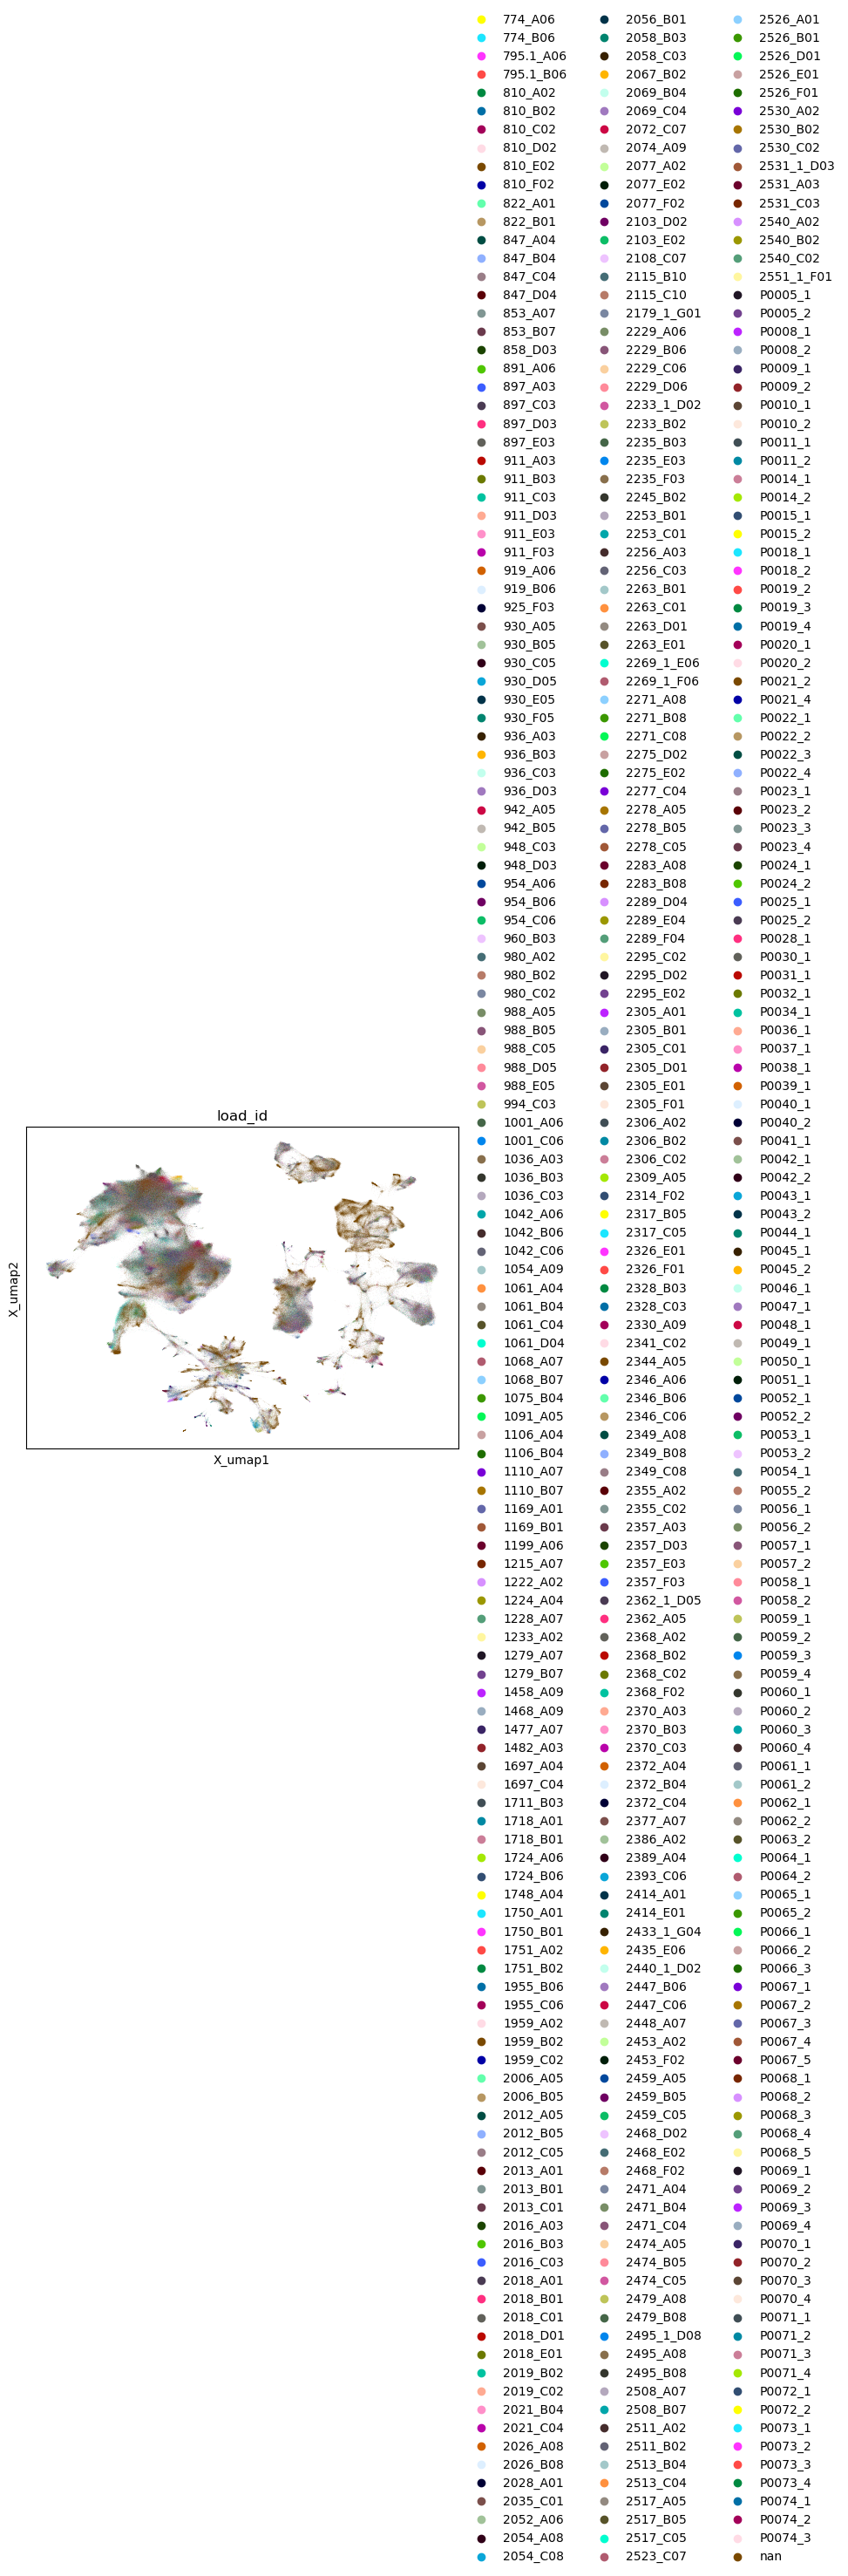

In [15]:
sc.pl.embedding(adata, basis='X_umap',color='load_id',palette=sc.pl.palettes.godsnot_102)

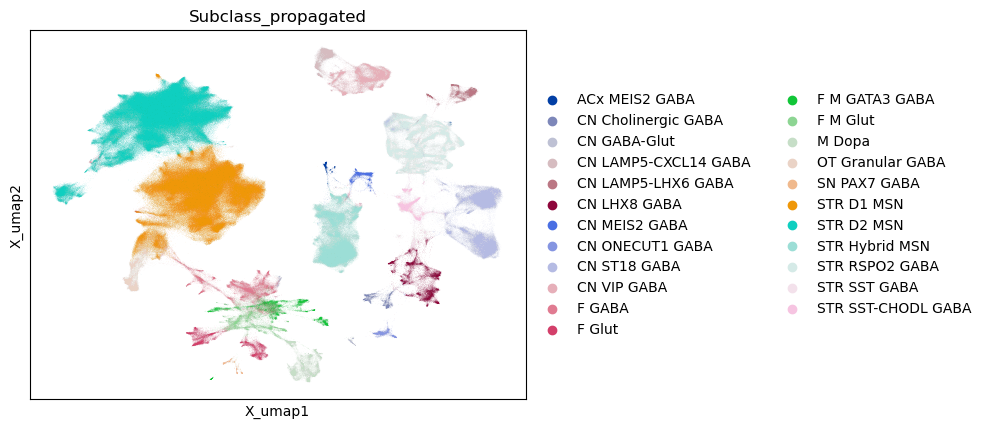

In [9]:
sc.pl.embedding(adata, basis='X_umap',color='Subclass_propagated')

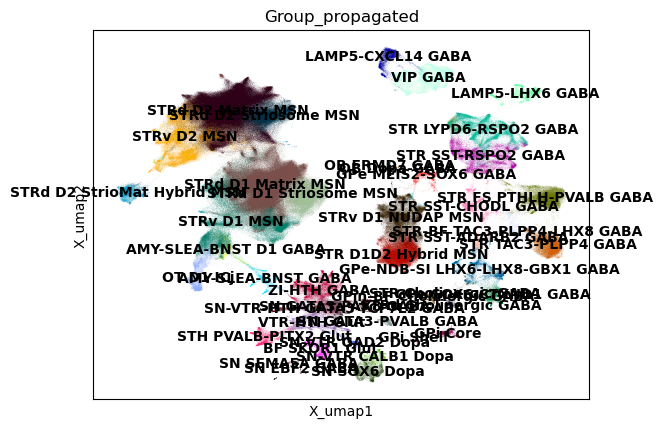

In [12]:
sc.pl.embedding(adata, basis='X_umap',color='Group_propagated',legend_loc='on data')

In [11]:
adata.write('/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/xspecies/BasalGanglia/HMBA_Human_Macaque_Marmoset_Mouse_snRNA-seq_BG_neuron_alignment_labeltransfer.h5ad')

In [18]:
del adata

In [3]:
adata = sc.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/xspecies/BasalGanglia/HMBA_Human_Macaque_Marmoset_Mouse_snRNA-seq_BG_alignment_v7.h5ad")

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
import h5py
import anndata
with h5py.File("/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/xspecies/BasalGanglia/HMBA_Human_Macaque_Marmoset_Mouse_snRNA-seq_BG_neuron_alignment_labeltransfer.h5ad") as f:
    obsm = anndata.experimental.read_elem(f['obsm'])
    obs = anndata.experimental.read_elem(f['obs'])
    var = anndata.experimental.read_elem(f['var'])

# adata_hvg = adata[:,var.index]
# adata_hvg = adata_hvg[obs.index,:]

# adata_trim = ~(adata.obs["AIT21.nbhd"].isin(["NN-IMN-GC"]) | adata.obs["Neighborhood"].isin(["Nonneuron"]))
# adata = adata[adata_trim]
# adata.obsm = obsm

# import scvi
# model= scvi.model.SCVI.load(dir_path="/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/xspecies/BasalGanglia/pre-print-integration_v6/",adata=adata_hvg.copy())

# ## Save the latent space from scVI for downstream analysis
# adata.obsm["X_scVI"] = model.get_latent_representation()

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_elem from `anndata.experimental` is deprecated. Import anndata.io.read_elem instead.
  warnings.warn(msg, FutureWarning)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_elem from `anndata.experimental` is deprecated. Import anndata.io.read_elem instead.
  warnings.warn(msg, FutureWarning)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_elem from `anndata.experimental` is deprecated. Import anndata.io.read_elem instead.
  warnings.warn(msg, FutureWarning)


In [5]:
for k in obsm.keys():
    obsm[k] = pd.DataFrame(obsm[k],index=obs.index)

In [6]:
adata = adata[~adata.obs.index.duplicated(),:]
obs = obs.loc[~obs.index.duplicated()]
for k in obsm.keys():
    obsm[k] = obsm[k].loc[~obsm[k].index.duplicated()]

In [7]:
# adata.obs_names_make_unique()

In [8]:
adata.obs.index.duplicated().sum()

np.int64(0)

In [9]:
obs.index.duplicated().sum()

np.int64(0)

In [10]:
adata

View of AnnData object with n_obs × n_vars = 2269411 × 15466
    obs: 'Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster', 'cluster_id', 'cell_type_ontology_term', 'load_id', 'donor_id', 'assay', 'assay_ontology_term_id', 'organism', 'organism_ontology_term_id', 'development_stage', 'anatomical_region', 'anatomical_region_merged', 'anatomical_region_ontology_term_id', 'brain_region_ontology_term_id', 'self_reported_sex', 'self_reported_sex_ontology_term_id', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'disease', 'disease_ontology_term_id', 'suspension_type', 'is_primary_data', 'total_counts', 'total_genes', 'doublet_score', 'organism_sci', 'accession_group', 'embedding_set', 'CL:ID_group', 'tokens_group', 'display_order_group', 'literature_support', 'literature_name_short', 'literature_name_long', 'curated_markers', 'color_hex_group', 'color_group', 'accession_subclass', 'CL:ID_subclass', 'tokens_subclass', 'display_order_subclass', 'color_hex_subclass', 

In [11]:
obs

,Neighborhood,Class,Subclass,Group,Cluster,cluster_id,cell_type_ontology_term,load_id,donor_id,assay,...,ClusterNm_y,derived_cell_libs_y,dataset,leiden_X_scVI,_scvi_batch,_scvi_labels,log10_n_counts,Group_propagated,Subclass_propagated,Class_propagated
AAACCAACAAGGTACG-2362_A05,Subpallium GABA,CN LGE GABA,STR D1 MSN,STRv D1 MSN,Human-154,Human-154,CL:0000003,2362_A05,H24.30.001,10x multiome,...,nan,nan,nan,0,1,0,3.938470,STRv D1 MSN,STR D1 MSN,CN LGE GABA
AAACCAACATGAAGTA-2362_A05,Subpallium GABA,CN LGE GABA,STR D2 MSN,STRd D2 Matrix MSN,Human-563,Human-563,CL:0000003,2362_A05,H24.30.001,10x multiome,...,nan,nan,nan,16,1,0,4.237116,STRd D2 Matrix MSN,STR D2 MSN,CN LGE GABA
AAACCGAAGTAGAGGC-2362_A05,Subpallium GABA,CN LGE GABA,STR D2 MSN,STRd D2 Matrix MSN,Human-563,Human-563,CL:0000003,2362_A05,H24.30.001,10x multiome,...,nan,nan,nan,15,1,0,4.198520,STRd D2 Matrix MSN,STR D2 MSN,CN LGE GABA
AAACCGCGTACGTTTC-2362_A05,Subpallium GABA,CN LGE GABA,STR D1 MSN,STRd D1 Matrix MSN,Human-512,Human-512,CL:0000003,2362_A05,H24.30.001,10x multiome,...,nan,nan,nan,10,1,0,3.719580,STRd D1 Matrix MSN,STR D1 MSN,CN LGE GABA
AAACCGCGTGATTTGG-2362_A05,Subpallium GABA,CN LGE GABA,STR D1 MSN,STRv D1 MSN,Human-155,Human-155,CL:0000003,2362_A05,H24.30.001,10x multiome,...,nan,nan,nan,0,1,0,4.309779,STRv D1 MSN,STR D1 MSN,CN LGE GABA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pBICCNsMMrTHT6iF016d210330A1_GATCGTAGTACAAACA,nan,nan,nan,nan,nan,nan,nan,nan,mouse,nan,...,Ex_Lypd6b_Dipk1c_1,pBICCNsMMrTHT6iF016d210330A1,WMB_TH-EPI-Glut,36,3,0,3.288249,ZI-HTH GABA,F M Glut,F M Glut
pBICCNsMMrTHT2iM013d210224A2_CCACCATCAGGTCAAG,nan,nan,nan,nan,nan,nan,nan,nan,mouse,nan,...,Ex_Irx2_Col2a1_1,pBICCNsMMrTHT2iM013d210224A2,WMB_TH-EPI-Glut,37,3,0,2.903633,VTR-HTH Glut,F M Glut,F M Glut
pBICCNsMMrTHT2iM013d210224A1_TCTATACTCTCATTGT,nan,nan,nan,nan,nan,nan,nan,nan,mouse,nan,...,Ex_Irx2_Col2a1_1,pBICCNsMMrTHT2iM013d210224A1,WMB_TH-EPI-Glut,36,3,0,3.318898,SN-VTR-HTH GATA3-TCF7L2 GABA,F M Glut,F M Glut
pBICCNsMMrTHT6iM018d210407A1_TTTAGTCCAGGGTTGA,nan,nan,nan,nan,nan,nan,nan,nan,mouse,nan,...,Ex_Lypd6b_Dipk1c_1,pBICCNsMMrTHT6iM018d210407A1,WMB_TH-EPI-Glut,37,3,0,3.824321,VTR-HTH Glut,F M Glut,F M Glut


In [12]:
# obs = obs.loc[adata.obs.index[adata.obs.index.isin(obs.index)]]
# adata = adata[[str(x) for x in obs.index],:]
# adata.obs = obs

In [13]:
obs = obs.loc[adata.obs.index[adata.obs.index.isin(obs.index)]]
adata = adata[[str(x) for x in obs.index], :]
obs = obs.loc[adata.obs_names]

In [14]:
adata.obs = adata.obs.copy()

In [15]:
for col in ['Group_propagated', 'Subclass_propagated', 'Class_propagated']:
    print(col)
    adata.obs[col] = list(obs[col].astype(obs[col].dtype))

for k in obsm.keys():
    adata.obsm[k] = obsm[k].loc[adata.obs_names].to_numpy()

Group_propagated
Subclass_propagated
Class_propagated


In [16]:
adata.obs

,Neighborhood,Class,Subclass,Group,Cluster,cluster_id,cell_type_ontology_term,load_id,donor_id,assay,...,library,sex,ClusterKey_y,ClusterNm_y,derived_cell_libs_y,dataset,log10_n_counts,Group_propagated,Subclass_propagated,Class_propagated
AAACCAACAAGGTACG-2362_A05,Subpallium GABA,CN LGE GABA,STR D1 MSN,STRv D1 MSN,Human-154,Human-154,CL:0000003,2362_A05,H24.30.001,10x multiome,...,NaN,NaN,NaN,NaN,NaN,NaN,4.468731,STRv D1 MSN,STR D1 MSN,CN LGE GABA
AAACCAACATGAAGTA-2362_A05,Subpallium GABA,CN LGE GABA,STR D2 MSN,STRd D2 Matrix MSN,Human-563,Human-563,CL:0000003,2362_A05,H24.30.001,10x multiome,...,NaN,NaN,NaN,NaN,NaN,NaN,4.762731,STRd D2 Matrix MSN,STR D2 MSN,CN LGE GABA
AAACCGAAGTAGAGGC-2362_A05,Subpallium GABA,CN LGE GABA,STR D2 MSN,STRd D2 Matrix MSN,Human-563,Human-563,CL:0000003,2362_A05,H24.30.001,10x multiome,...,NaN,NaN,NaN,NaN,NaN,NaN,4.718011,STRd D2 Matrix MSN,STR D2 MSN,CN LGE GABA
AAACCGCGTACGTTTC-2362_A05,Subpallium GABA,CN LGE GABA,STR D1 MSN,STRd D1 Matrix MSN,Human-512,Human-512,CL:0000003,2362_A05,H24.30.001,10x multiome,...,NaN,NaN,NaN,NaN,NaN,NaN,4.275657,STRd D1 Matrix MSN,STR D1 MSN,CN LGE GABA
AAACCGCGTGATTTGG-2362_A05,Subpallium GABA,CN LGE GABA,STR D1 MSN,STRv D1 MSN,Human-155,Human-155,CL:0000003,2362_A05,H24.30.001,10x multiome,...,NaN,NaN,NaN,NaN,NaN,NaN,4.849229,STRv D1 MSN,STR D1 MSN,CN LGE GABA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pBICCNsMMrS1iF022d210713A6_TCGCTCATCACCGGGT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pBICCNsMMrS1iF022d210713A6,mouse,NaN,...,pBICCNsMMrS1iF022d210713A6,female,300-0-0-0-0-1-0-0,Inh_Lhx6_Pvalb_Tac1,pBICCNsMMrS1iF022d210713A6,WMB_Subpallium-GABA,4.363029,STR LYPD6-RSPO2 GABA,STR RSPO2 GABA,CN MGE GABA
pBICCNsMMrTHT6iF016d210330A3_TCCGTGTGTTATCCAG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pBICCNsMMrTHT6iF016d210330A3,mouse,NaN,...,pBICCNsMMrTHT6iF016d210330A3,female,300-0-0-0-0-0-0-3-0-0,Ex_Lypd6b_Dipk1c_1,pBICCNsMMrTHT6iF016d210330A3,WMB_TH-EPI-Glut,3.851014,VTR-HTH Glut,F M Glut,F M Glut
pBICCNsMMrTHT6iF016d210330A1_GATCGTAGTACAAACA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pBICCNsMMrTHT6iF016d210330A1,mouse,NaN,...,pBICCNsMMrTHT6iF016d210330A1,female,300-0-0-0-0-0-0-3-0-0,Ex_Lypd6b_Dipk1c_1,pBICCNsMMrTHT6iF016d210330A1,WMB_TH-EPI-Glut,3.815445,ZI-HTH GABA,F M Glut,F M Glut
pBICCNsMMrTHT6iM018d210407A1_TTTAGTCCAGGGTTGA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pBICCNsMMrTHT6iM018d210407A1,mouse,NaN,...,pBICCNsMMrTHT6iM018d210407A1,male,300-0-0-0-0-0-0-3-0-0,Ex_Lypd6b_Dipk1c_1,pBICCNsMMrTHT6iM018d210407A1,WMB_TH-EPI-Glut,4.279462,VTR-HTH Glut,F M Glut,F M Glut


In [17]:
adata

AnnData object with n_obs × n_vars = 1298997 × 15466
    obs: 'Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster', 'cluster_id', 'cell_type_ontology_term', 'load_id', 'donor_id', 'assay', 'assay_ontology_term_id', 'organism', 'organism_ontology_term_id', 'development_stage', 'anatomical_region', 'anatomical_region_merged', 'anatomical_region_ontology_term_id', 'brain_region_ontology_term_id', 'self_reported_sex', 'self_reported_sex_ontology_term_id', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'disease', 'disease_ontology_term_id', 'suspension_type', 'is_primary_data', 'total_counts', 'total_genes', 'doublet_score', 'organism_sci', 'accession_group', 'embedding_set', 'CL:ID_group', 'tokens_group', 'display_order_group', 'literature_support', 'literature_name_short', 'literature_name_long', 'curated_markers', 'color_hex_group', 'color_group', 'accession_subclass', 'CL:ID_subclass', 'tokens_subclass', 'display_order_subclass', 'color_hex_subclass', 'color_s

In [19]:
adata.obs.groupby('Group')['Subclass'].value_counts().unstack().idxmax(1).to_dict()

/scratch/fast/4176469/ipykernel_3305390/3944938090.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('Group')['Subclass'].value_counts().unstack().idxmax(1).to_dict()


{'AMY-SLEA-BNST D1 GABA': 'F GABA',
 'AMY-SLEA-BNST GABA': 'F GABA',
 'BF SKOR1 Glut': 'F Glut',
 'GPe MEIS2-SOX6 GABA': 'CN MEIS2 GABA',
 'GPe SOX6-CTXND1 GABA': 'CN LHX8 GABA',
 'GPe-NDB-SI LHX6-LHX8-GBX1 GABA': 'CN LHX8 GABA',
 'GPi Core': 'CN ONECUT1 GABA',
 'GPi Shell': 'CN GABA-Glut',
 'GPin-BF Cholinergic GABA': 'CN Cholinergic GABA',
 'LAMP5-CXCL14 GABA': 'CN LAMP5-CXCL14 GABA',
 'LAMP5-LHX6 GABA': 'CN LAMP5-LHX6 GABA',
 'OB Dopa-GABA': 'ACx MEIS2 GABA',
 'OB FRMD7 GABA': 'ACx MEIS2 GABA',
 'OT D1 ICj': 'OT Granular GABA',
 'SN EBF2 GABA': 'SN PAX7 GABA',
 'SN GATA3-PAX8 GABA': 'F M GATA3 GABA',
 'SN GATA3-PVALB GABA': 'F M GATA3 GABA',
 'SN SEMA5A GABA': 'SN PAX7 GABA',
 'SN SOX6 Dopa': 'M Dopa',
 'SN-VTR CALB1 Dopa': 'M Dopa',
 'SN-VTR GAD2 Dopa': 'M Dopa',
 'SN-VTR-HTH GATA3-TCF7L2 GABA': 'F M GATA3 GABA',
 'STH PVALB-PITX2 Glut': 'F Glut',
 'STR Cholinergic GABA': 'CN Cholinergic GABA',
 'STR D1D2 Hybrid MSN': 'STR Hybrid MSN',
 'STR FS PTHLH-PVALB GABA': 'CN ST18 GABA',
 '

In [20]:
adata.obs['Subclass_propagated'] = adata.obs['Group_propagated'].replace(adata.obs.groupby('Group')['Subclass'].value_counts().unstack().idxmax(1).to_dict())
adata.obs['Class_propagated'] = adata.obs['Subclass_propagated'].replace(adata.obs.groupby('Subclass')['Class'].value_counts().unstack().idxmax(1).to_dict())

/scratch/fast/4176469/ipykernel_3305390/4171636635.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs['Subclass_propagated'] = adata.obs['Group_propagated'].replace(adata.obs.groupby('Group')['Subclass'].value_counts().unstack().idxmax(1).to_dict())
/scratch/fast/4176469/ipykernel_3305390/4171636635.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs['Class_propagated'] = adata.obs['Subclass_propagated'].replace(adata.obs.groupby('Subclass')['Class'].value_counts().unstack().idxmax(1).to_dict())


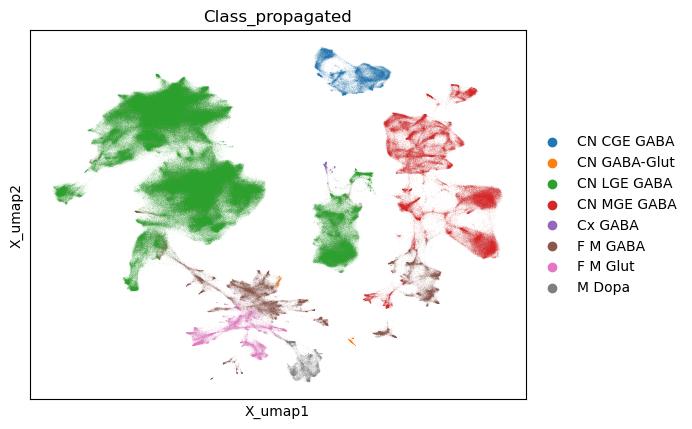

In [22]:
sc.pl.embedding(adata, basis='X_umap',color='Class_propagated')

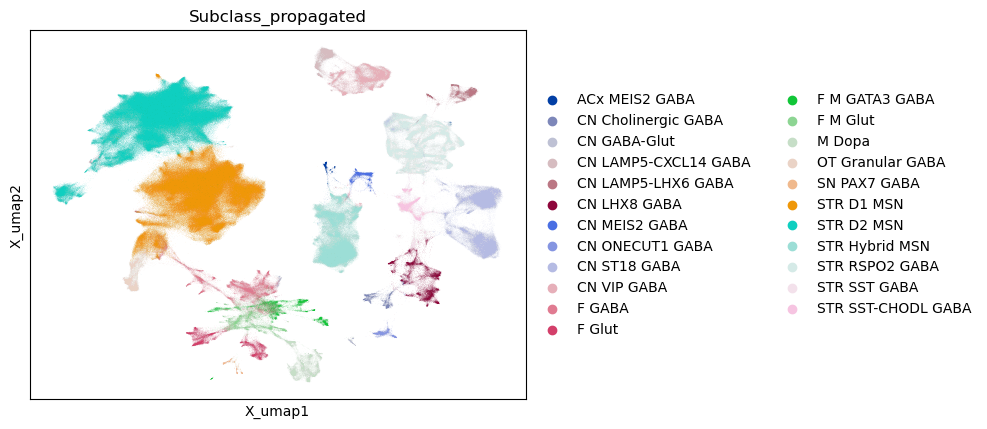

In [21]:
sc.pl.embedding(adata, basis='X_umap',color='Subclass_propagated')

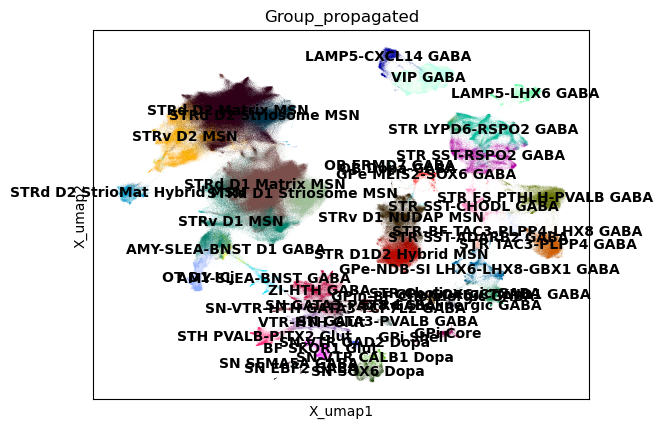

In [26]:
sc.pl.embedding(adata, basis='X_umap',color='Group_propagated',legend_loc='on data')

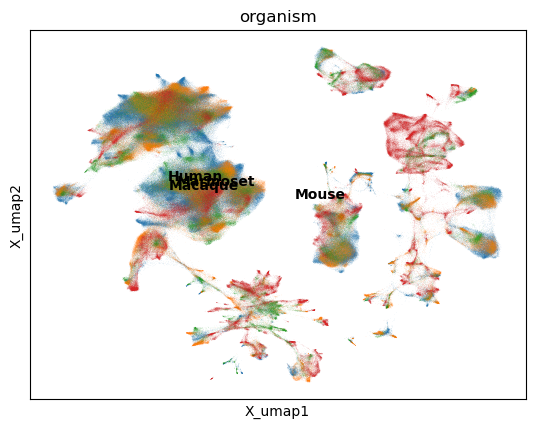

In [27]:
sc.pl.embedding(adata, basis='X_umap',color='organism',legend_loc='on data')

In [ ]:
# adata.obs['organism'] = adata.obs['organism'].replace({'nan':'Mouse'})

In [26]:
adata.obs['self_reported_sex']

AAACCAACAAGGTACG-2362_A05                               Male
AAACCAACATGAAGTA-2362_A05                               Male
AAACCGAAGTAGAGGC-2362_A05                               Male
AAACCGCGTACGTTTC-2362_A05                               Male
AAACCGCGTGATTTGG-2362_A05                               Male
                                                       ...  
pBICCNsMMrS1iF022d210713A6_TCGCTCATCACCGGGT           Female
pBICCNsMMrTHT6iF016d210330A3_TCCGTGTGTTATCCAG         Female
pBICCNsMMrTHT6iF016d210330A1_GATCGTAGTACAAACA         Female
pBICCNsMMrTHT6iM018d210407A1_TTTAGTCCAGGGTTGA           Male
pBICCNsMMrHPFCA2CA3iF014d210217A2_CGCGTGAAGCTACAAA    Female
Name: self_reported_sex, Length: 1298997, dtype: category
Categories (2, object): ['Female', 'Male']

In [27]:
adata.write("/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/xspecies/BasalGanglia/HMBA_Human_Macaque_Marmoset_Mouse_snRNA-seq_BG_neuron_alignment_labeltransfer_allgenes.h5ad")